### Deep Neural Network

In [1]:
import math
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

The data can be obtained from https://www.kaggle.com/ardamavi/sign-language-digits-dataset (preprocessed) or https://github.com/ardamavi/Sign-Language-Digits-Dataset (raw).

__Load and Preprocess Data__

In [2]:
# load in sign language digits dataset with labels
X_raw = np.load(open('data/Sign-language-digits-dataset/X.npy', 'rb'))
y_raw = np.load(open('data/Sign-language-digits-dataset/Y.npy', 'rb'))
# shuffle up the data
randomize = np.arange(X_raw.shape[0])
np.random.shuffle(randomize)
X_raw = X_raw[randomize]
y_raw = y_raw[randomize]
# reformate data for later calculations
X_data = X_raw.reshape(X_raw.shape[0], -1).T
y_data = y_raw.T
# take 72% of data for training set, and the rest for testing set
idx = int(0.72 * X_data.shape[1])
X_train = X_data[:, :idx]
y_train = y_data[:, :idx]
X_test = X_data[:, idx:]
y_test = y_data[:, idx:]

__Visualize__

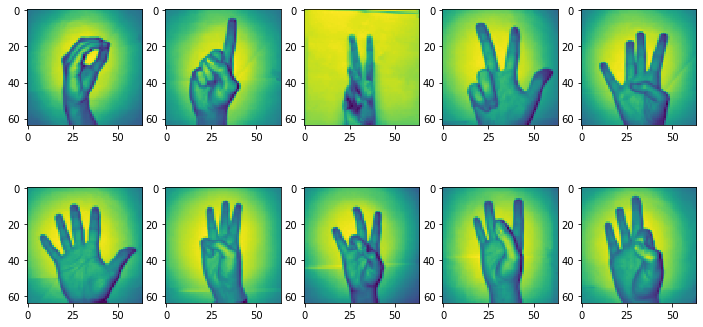

In [3]:
# Visualize random point of data for each category
img_cat0 = X_data[:, np.where(np.argmax(y_data, axis=0).reshape((1, y_data.shape[1])) == 1)[1]][:, 0].reshape((64,64))
img_cat1 = X_data[:, np.where(np.argmax(y_data, axis=0).reshape((1, y_data.shape[1])) == 4)[1]][:, 0].reshape((64,64))
img_cat2 = X_data[:, np.where(np.argmax(y_data, axis=0).reshape((1, y_data.shape[1])) == 8)[1]][:, 0].reshape((64,64))
img_cat3 = X_data[:, np.where(np.argmax(y_data, axis=0).reshape((1, y_data.shape[1])) == 7)[1]][:, 0].reshape((64,64))
img_cat4 = X_data[:, np.where(np.argmax(y_data, axis=0).reshape((1, y_data.shape[1])) == 6)[1]][:, 0].reshape((64,64))
img_cat5 = X_data[:, np.where(np.argmax(y_data, axis=0).reshape((1, y_data.shape[1])) == 9)[1]][:, 0].reshape((64,64))
img_cat6 = X_data[:, np.where(np.argmax(y_data, axis=0).reshape((1, y_data.shape[1])) == 3)[1]][:, 0].reshape((64,64))
img_cat7 = X_data[:, np.where(np.argmax(y_data, axis=0).reshape((1, y_data.shape[1])) == 2)[1]][:, 0].reshape((64,64))
img_cat8 = X_data[:, np.where(np.argmax(y_data, axis=0).reshape((1, y_data.shape[1])) == 5)[1]][:, 0].reshape((64,64))
img_cat9 = X_data[:, np.where(np.argmax(y_data, axis=0).reshape((1, y_data.shape[1])) == 0)[1]][:, 0].reshape((64,64))

fig = plt.figure(figsize=(12, 6))
fig.add_subplot(2, 5, 1)
plt.imshow(img_cat0)
fig.add_subplot(2, 5, 2)
plt.imshow(img_cat1)
fig.add_subplot(2, 5, 3)
plt.imshow(img_cat2)
fig.add_subplot(2, 5, 4)
plt.imshow(img_cat3)
fig.add_subplot(2, 5, 5)
plt.imshow(img_cat4)
fig.add_subplot(2, 5, 6)
plt.imshow(img_cat5)
fig.add_subplot(2, 5, 7)
plt.imshow(img_cat6)
fig.add_subplot(2, 5, 8)
plt.imshow(img_cat7)
fig.add_subplot(2, 5, 9)
plt.imshow(img_cat8)
fig.add_subplot(2, 5, 10)
plt.imshow(img_cat9)
plt.show()

__Initialize Model Parameters__

In [4]:
"""
init_params_deep() initializes the weight and bias parameters for a deep neural network

parameters:
    layer_widths - a list containing the sizes of the input layer, hidden layers, and the output layer
                   
returns: the initizlized weight and bias parameters for each layer
"""
def init_params_deep(layer_widths):
    np.random.seed(3)
    params = {}
    L = len(layer_widths)
    assert(L >= 2)
    # initialize parameters for all hidden layers
    for l in range(1, L-1):
        params['w' + str(l)] = np.random.randn(layer_widths[l], layer_widths[l-1])*np.sqrt(2/layer_widths[l-1])
        params['b' + str(l)] = np.zeros((layer_widths[l], 1))
    # initialize parameters for output layer
    params['w' + str(L-1)] = np.random.randn(layer_widths[L-1], layer_widths[L-2])*np.sqrt(1/layer_widths[L-2])
    params['b' + str(L-1)] = np.zeros((layer_widths[L-1], 1))
    return params

__Forward Propagation Functions__

In [5]:
"""
linear_forward() does the forward linear computation

parameters:
    a_prev - activations from the previous layer
    w - weight matrix
    b - bias vector
                   
returns:
    z - output of the forward linear computation
    linear_cache - a cache of previous activations, weight matrix, and bias vector
"""
def linear_forward(a_prev, w, b):
    # dot product of weight matrix with previous activations, then add bias vector
    z = w.dot(a_prev) + b
    linear_cache = (a_prev, w, b)
    return z, linear_cache

In [6]:
"""
activation_forward() does the forward activation computation

parameters:
    z - output from forward linear module
                   
returns:
    a - output of the forward activation computation
    z - a cache of the input
"""
def activation_forward(z, activation):
    # use relu activation function for hidden layers, and softmax activation function for output layer
    assert(activation == 'softmax' or activation == 'relu')
    if activation == 'softmax':
        a = np.exp(z) / np.sum(np.exp(z), axis=0, keepdims=True)
    else:
        a = np.maximum(z, 0)
    return a, z

In [7]:
"""
forward() does the forward linear and activation computations for a single layer

parameters:
    a_prev - activations from the previous layer
    w - weight matrix
    b - bias vector
    activation - string stating which activation function to use
                   
returns:
    a - output of the forward activation computation.
    cache - a cache of the inputs to the forward linear and activation computations
"""
def forward(a_prev, w, b, activation):
    # do the linear computation, then run its output through an activation function
    z, linear_cache = linear_forward(a_prev, w, b)
    a, activation_cache = activation_forward(z, activation)
    cache = (linear_cache, activation_cache)
    return a, cache

In [8]:
"""
forward_deep() does the forward computations for each layer in the deep neural network

parameters:
    X - the input data
    params - the initialized weight and bias parameters
                   
returns:
    a - the activation of the output layer
    caches - a list of caches from each layer
"""
def forward_deep(X, params):
    caches = []
    a_prev = X
    L = len(params) // 2
    # forward computation of all hidden layers, with relu activation function
    for layer in range(1, L):
        w = params['w' + str(layer)]
        b = params['b' + str(layer)]
        a, cache = forward(a_prev, w, b, 'relu')
        caches.append(cache)
        a_prev = a
    # forward computation of output layer, with softmax activation function
    w = params['w' + str(L)]
    b = params['b' + str(L)]
    a, cache = forward(a_prev, w, b, 'softmax')
    caches.append(cache)
    return a, caches

__Backward Propagation Functions__

In [9]:
"""
activation_backward() does the backward activation computation to obtain gradients

parameters:
    da - gradients from the previous layer in backwards computation
    activation_cache - the activations from forwards computation
    activation - string specifying which activation function was used
                   
returns:
    dz - gradient of loss with respect to z
"""
def activation_backward(da, activation_cache, activation):
    assert(activation == 'softmax' or activation == 'relu')
    # if softmax function, dz will be passed in.  If relu function, multiply da by 1 if activation_cache is greater
    # than zero, and multyply da by zero if activation_cache is less than or equal to zero, in order to get dz
    if activation == 'softmax':
        dz = da
    else:
        z = activation_cache
        dz = np.array(da, copy=True)
        dz[z <= 0] = 0
    return dz

In [10]:
"""
linear_backward() does the backward linear computation to obtain gradients

parameters:
    dz - gradient passed from activation_backward()
    linear_cache - cache of activations, weight matrix, and bias vector from forward computation
                   
returns:
    da_prev - gradient to pass to the next layer in backwards computation
    dw - gradient of weight matrix for a given layer
    db - gradient of bias vector for a given layer
"""
def linear_backward(dz, linear_cache):
    a_prev, w, b = linear_cache
    m = a_prev.shape[1]
    # compute gradients of weight matrix and bias vector for a layer, and gradients of activations for the next layer
    dw = (1/m)*dz.dot(a_prev.T)
    db = (1/m)*np.sum(dz, axis=1, keepdims=True)
    da_prev = w.T.dot(dz)
    return da_prev, dw, db

In [11]:
"""
backward() does the backward activation and linear gradient computations for a single layer

parameters:
    a_prev - activations from the previous layer
    w - weight matrix
    b - bias vector
    activation - string stating which activation function to use
                   
returns:
    a - output of the forward activation computation.
    cache - a cache of the inputs to the forward linear and activation computations
"""
def backward(da, cache, activation):
    # calculate gradients for a layer, first with activation, then with linear computations
    linear_cache, activation_cache = cache
    dz = activation_backward(da, activation_cache, activation)
    da_prev, dw, db = linear_backward(dz, linear_cache)
    return da_prev, dw, db

In [12]:
"""
backward_deep() does the backward gradient computations for each layer in the deep neural network

parameters:
    a - predictions output from the forward propagation
    y - true one-hot label vector
    caches - list of caches output from forward propagation
                   
returns:
    gradients - a dictionary containing the gradients for the weights and bias for each layer
"""
def backward_deep(a, y, caches):
    gradients = {}
    L = len(caches)
    # dz for softmax layer using cross entropy loss function is predictions minus truth
    dz = a - y
    current_cache = caches[L-1]
    # compute backwards gradients for output layer
    da_prev, dw, db = backward(dz, current_cache, 'softmax')
    gradients['dw' + str(L)] = dw
    gradients['db' + str(L)] = db
    da = da_prev
    # compute backwards gradients for hidden layers
    for layer in reversed(range(1, L)):
        current_cache = caches[layer-1]
        da_prev, dw, db = backward(da, current_cache, 'relu')
        gradients['dw' + str(layer)] = dw
        gradients['db' + str(layer)] = db
        da = da_prev
    return gradients

__Update Model Parameters__

In [13]:
"""
update_parameters() updates the weight and bias parameters given the gradients and the learning rate

parameters:
    params - weights and bias parameters
    gradients - gradients of weights and bias parameters
    alpha - learning rate
                   
returns:
    params - updated paramters
"""
def update_parameters(params, gradients, alpha):
    L = len(params) // 2
    # for each layer, update the weight and bias parameters using gradients and learning rate
    for layer in range(1, L):
        params['w' + str(layer)] -= alpha*gradients['dw' + str(layer)]
        params['b' + str(layer)] -= alpha*gradients['db' + str(layer)]
    return params

__Training__

In [14]:
"""
dnn_model() trains a deep neural network and returns the model weight and bias parameters along with training loss.
This model uses a relu activation function for the hidden layers, a softmax activation function for the output layer.
It uses a cross entropy loss function.  The model depth and layer breadth can be specified for the hidden layers.

parameters:
    X - data features
    y - data labels (should be one hot labels)
    hidden_layer_widths - list specifying layer breadth for each hidden layer
    alpha - learning rate
    epochs - how many times model will be trained on data
    verbose - boolean specifying if output updates are desired during training
                   
returns:
    params - parameters for trained model
    losses - list of losses for each epoch
"""
def dnn_model(X, y, hidden_layer_widths, alpha=0.001, epochs=5000, verbose=False):
    # determine the number of data points
    m = X.shape[1]
    # determine number of data features
    input_dim = X.shape[0]
    # determine the number of classifications
    output_dim = y.shape[0]
    # initialize weight and bias parameters for all layers
    layer_widths = [input_dim] + hidden_layer_widths + [output_dim]
    params = init_params_deep(layer_widths)
    losses = []
    for epoch in range(epochs):
        # make predictions with forward pass of data
        a, caches = forward_deep(X, params)
        # calculate parameter gradients in backward pass
        gradients = backward_deep(a, y, caches)
        # update parameters with gradients and learning rate
        params = update_parameters(params, gradients, alpha)
        # use cross entropy loss function
        loss = -(1/m)*np.sum(y*np.log(a))
        losses.append(loss)
        if verbose and epoch % 500 == 0:
            print('epoch: ' + str(epoch))
            print('loss: ' + str(loss))
            print()
    return params, losses

__Testing__

In [15]:
"""
predict() will choose one of the classification labels given data features and model parameters

parameters:
    X - data features
    params - model parameters
                   
returns:
    a - classification label predictions for data
"""
def predict(X, params):
    # make predictions
    a, _ = forward_deep(X, params)
    return a

__Train and Test Model__

In [16]:
# set learning rate, epochs, and hidden layer structure
alpha = 0.002
epochs = 10000
verbose = False
hidden_layer_widths = [75, 50, 25]
# train a deep neural network with training data
params, losses = dnn_model(X_train, y_train, hidden_layer_widths, alpha, epochs, verbose)
# make predictions with test data and trained model parameters
predictions = predict(X_test, params)

__Model Evaluation__

In [17]:
# calculate and print error rate
y_pred = np.argmax(predictions, axis=0)
y_true = np.argmax(y_test, axis=0)
error_rate = np.count_nonzero(y_pred != y_true) / y_test.shape[1]
error_rate = math.floor(error_rate * 10000) / 100.0
print('Error Rate of {}%'.format(error_rate))

Error Rate of 23.87%


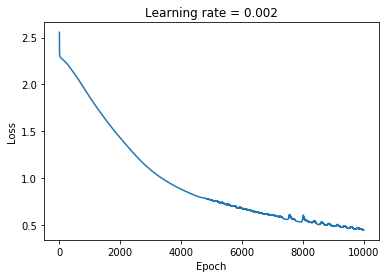

In [18]:
# plot loss as function of epochs
plt.plot(losses)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Learning rate = {}'.format(alpha))
plt.show()

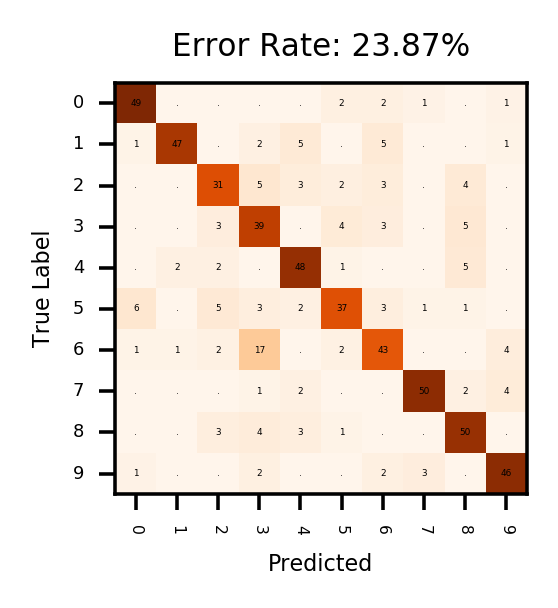

In [19]:
# confusion matrix
N = y_test.shape[0]
labels = [i for i in range(0,10)]
label_indices = [x for x in range(N)]
confusion = confusion_matrix(y_true, y_pred)

# Build the figure and axes            
fig = plt.figure(figsize=(2,2), dpi=320)
ax = fig.add_subplot(1, 1, 1)

# Show the heat map relative to the number of true examples so that the most frequent decisions are always highlighted
relative = confusion / confusion.sum(axis=1)[:,None]
im = ax.imshow(relative, cmap='Oranges')

# Label the axes
tick_marks = np.arange(N)

ax.set_xlabel('Predicted', fontsize=5)
ax.set_xticks(tick_marks)
ax.set_xticklabels(labels, fontsize=3.5, rotation=-90,  ha='center')
ax.xaxis.set_label_position('bottom')

ax.set_ylabel('True Label', fontsize=5)
ax.set_yticks(tick_marks)
ax.set_yticklabels(labels, fontsize=4, va ='center')
ax.yaxis.set_label_position('left')
ax.yaxis.tick_left()

# Add counts in boxes
for i, j in itertools.product(range(confusion.shape[0]), range(confusion.shape[1])):
    ax.text(j, i, format(confusion[i, j], 'd') if confusion[i,j] !=0 else '.', 
            horizontalalignment="center", fontsize=2,
            verticalalignment='center', color= "black")

# show confusion matrix
fig.set_tight_layout(True)
plt.title("Error Rate: {}%".format(error_rate), fontsize=7)
plt.show()